# 03. Model Prototyping and Tuning

Este notebook se enfoca en el entrenamiento, evaluación y optimización de modelos de clasificación.

## Contenido:
1. Cargar datos y pipeline de features
2. Baseline model (Logistic Regression)
3. Modelos avanzados (Random Forest, XGBoost, LightGBM)
4. Manejo de desbalanceo de clases
5. Hyperparameter tuning
6. Comparación de modelos
7. Selección del mejor modelo

## 1. Imports y Configuración

## 2. Definir Transformadores Personalizados

Necesitamos redefinir las clases antes de cargar el pipeline

## 2. Definir Transformadores Personalizados

Necesitamos redefinir las clases antes de cargar el pipeline

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Imports cargados correctamente')

✅ Imports cargados correctamente


## 2. Definir Transformadores Personalizados

Necesitamos redefinir las clases antes de cargar el pipeline

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class RareGrouper(BaseEstimator, TransformerMixin):
    """
    Agrupa categorías raras en 'OTHER'.
    
    Parameters:
    -----------
    min_pct : float
        Umbral de frecuencia mínima (default: 0.01 = 1%)
        Categorías con frecuencia menor a este valor se agrupan.
    
    Example:
    --------
    >>> rg = RareGrouper(min_pct=0.05)  # Agrupar categorías con < 5%
    >>> rg.fit_transform(df[['categorical_col']])
    """
    def __init__(self, min_pct=0.01):
        self.min_pct = min_pct
        self.mappings = {}
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            rare = freq[freq < self.min_pct].index.tolist()
            self.mappings[col] = set(rare)
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, rare_set in self.mappings.items():
            X[col] = X[col].where(~X[col].isin(rare_set), 'OTHER')
        return X


class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Crea features derivadas para el modelo de riesgo crediticio.
    
    Features creadas:
    ----------------
    1. is_emp_length_missing: Flag binario para missing values en employment length
    2. is_loan_int_rate_missing: Flag binario para missing values en interest rate
    3. log_person_income: Transformación logarítmica del ingreso
    4. log_loan_amnt: Transformación logarítmica del monto del préstamo
    5. income_to_loan: Ratio ingreso/monto del préstamo
    6. cred_hist_ratio: Ratio historial crediticio/edad
    7. age_bucket: Categorización de edad en bins
    8. loan_amt_rate_inter: Interacción monto × tasa de interés
    
    Parameters:
    -----------
    age_bins : list
        Límites de bins para categorizar edad (default: [18, 25, 35, 50, 100])
    """
    def __init__(self, age_bins=[18, 25, 35, 50, 100]):
        self.age_bins = age_bins
        self.income_q01 = None
        self.income_q99 = None
        self.median_loan_rate = None
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Guardar estadísticas del training set
        self.income_q01 = X['person_income'].quantile(0.01)
        self.income_q99 = X['person_income'].quantile(0.99)
        self.median_loan_rate = X['loan_int_rate'].median()
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        
        # 1. Flags de missing values
        X['is_emp_length_missing'] = X['person_emp_length'].isnull().astype(int)
        X['is_loan_int_rate_missing'] = X['loan_int_rate'].isnull().astype(int)
        
        # 2. Transformaciones logarítmicas (log1p maneja zeros)
        X['log_person_income'] = np.log1p(X['person_income'].fillna(0))
        X['log_loan_amnt'] = np.log1p(X['loan_amnt'].fillna(0))
        
        # 3. Features de ratio
        X['income_to_loan'] = X['person_income'] / (1 + X['loan_amnt'].fillna(0))
        X['cred_hist_ratio'] = X['cb_person_cred_hist_length'] / (1 + X['person_age'].fillna(0))
        
        # 4. Age buckets (como string para OneHotEncoding posterior)
        X['age_bucket'] = pd.cut(
            X['person_age'].fillna(-1),
            bins=self.age_bins,
            labels=False,
            include_lowest=True
        ).astype('Int64').astype(str)
        
        # 5. Feature de interacción
        X['loan_amt_rate_inter'] = X['loan_amnt'] * X['loan_int_rate'].fillna(self.median_loan_rate)
        
        # 6. Clipping de outliers en income (usando quantiles del train set)
        X['person_income'] = X['person_income'].clip(
            lower=self.income_q01,
            upper=self.income_q99
        )
        
        return X

def binary_mapping(df):
    return pd.DataFrame(df).replace({'Y': 1, 'N': 0}).astype(float)


## 3. Cargar Datos y Pipeline

In [23]:
# Cargar pipeline de feature engineering
feature_pipeline = joblib.load('feature_engineering_pipeline.pkl')
print("✅ Pipeline de feature engineering cargado")

# Cargar configuración
config = joblib.load('feature_engineering_config.pkl')
print("✅ Configuración cargada")

# Cargar datos transformados
data = joblib.load('transformed_data.pkl')
X_train = data['X_train_transformed']
y_train = data['y_train']
X_test = data['X_test_transformed']
y_test = data['y_test']

print(f"\n📊 Datos cargados:")
print(f"  Train: {X_train.shape}")
print(f"  Test: {X_test.shape}")
print(f"\n🎯 Distribución del target:")
print(f"  No Default (0): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  Default (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")
print(f"  Ratio de desbalanceo: 1:{(y_train == 0).sum() / (y_train == 1).sum():.2f}")

✅ Pipeline de feature engineering cargado
✅ Configuración cargada

📊 Datos cargados:
  Train: (26064, 30)
  Test: (6517, 30)

🎯 Distribución del target:
  No Default (0): 20,378 (78.18%)
  Default (1): 5,686 (21.82%)
  Ratio de desbalanceo: 1:3.58


## 3. Baseline Model - Logistic Regression

In [24]:
# Logistic Regression con class_weight='balanced'
baseline_lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("🔧 Entrenando Logistic Regression (baseline)...")
baseline_lr.fit(X_train, y_train)

# Predicciones
y_pred_lr = baseline_lr.predict(X_test)
y_proba_lr = baseline_lr.predict_proba(X_test)[:, 1]

# Evaluación
print("\n" + "="*60)
print("BASELINE MODEL - LOGISTIC REGRESSION")
print("="*60)
print(classification_report(y_test, y_pred_lr, target_names=['No Default', 'Default']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")

🔧 Entrenando Logistic Regression (baseline)...

BASELINE MODEL - LOGISTIC REGRESSION
              precision    recall  f1-score   support

  No Default       0.94      0.81      0.87      5095
     Default       0.54      0.80      0.65      1422

    accuracy                           0.81      6517
   macro avg       0.74      0.81      0.76      6517
weighted avg       0.85      0.81      0.82      6517

ROC-AUC Score: 0.8770
F1 Score: 0.6466


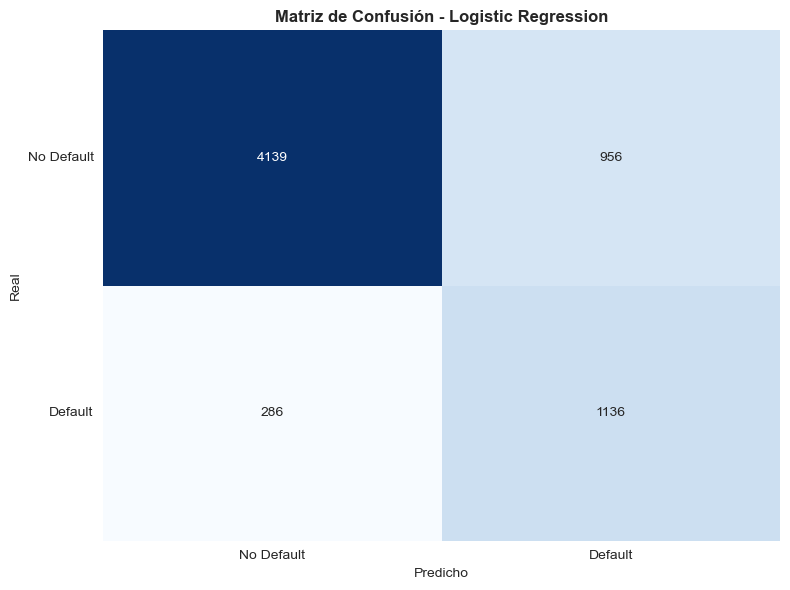


📊 Análisis de la matriz de confusión:
  True Negatives (TN): 4,139
  False Positives (FP): 956 - Falsa alarma: 18.76%
  False Negatives (FN): 286 - Defaults perdidos: 20.11%
  True Positives (TP): 1,136


In [25]:
# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Logistic Regression', fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.xticks([0.5, 1.5], ['No Default', 'Default'])
plt.yticks([0.5, 1.5], ['No Default', 'Default'], rotation=0)
plt.tight_layout()
plt.show()

# Calcular tasas
tn, fp, fn, tp = cm_lr.ravel()
print(f"\n📊 Análisis de la matriz de confusión:")
print(f"  True Negatives (TN): {tn:,}")
print(f"  False Positives (FP): {fp:,} - Falsa alarma: {fp/(fp+tn)*100:.2f}%")
print(f"  False Negatives (FN): {fn:,} - Defaults perdidos: {fn/(fn+tp)*100:.2f}%")
print(f"  True Positives (TP): {tp:,}")

## 4. Modelos Avanzados

In [26]:
# Definir modelos a comparar
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

print(f"\n📋 Modelos a evaluar: {len(models)}")
for name in models.keys():
    print(f"  • {name}")


📋 Modelos a evaluar: 3
  • Logistic Regression
  • Random Forest
  • Gradient Boosting


In [27]:
# Cross-validation para cada modelo
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n🔄 Ejecutando cross-validation (5-fold estratificado)...\n")

for name, model in models.items():
    print(f"Evaluando {name}...")
    
    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    cv_results[name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    
    print(f"  ROC-AUC: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print()

print("✅ Cross-validation completado")


🔄 Ejecutando cross-validation (5-fold estratificado)...

Evaluando Logistic Regression...
  ROC-AUC: 0.8761 (+/- 0.0031)

Evaluando Random Forest...
  ROC-AUC: 0.9292 (+/- 0.0074)

Evaluando Gradient Boosting...
  ROC-AUC: 0.9481 (+/- 0.0080)

✅ Cross-validation completado



📊 Resultados de Cross-Validation:
              Model  Mean_AUC  Std_AUC
  Gradient Boosting  0.948149 0.003976
      Random Forest  0.929243 0.003693
Logistic Regression  0.876089 0.001569


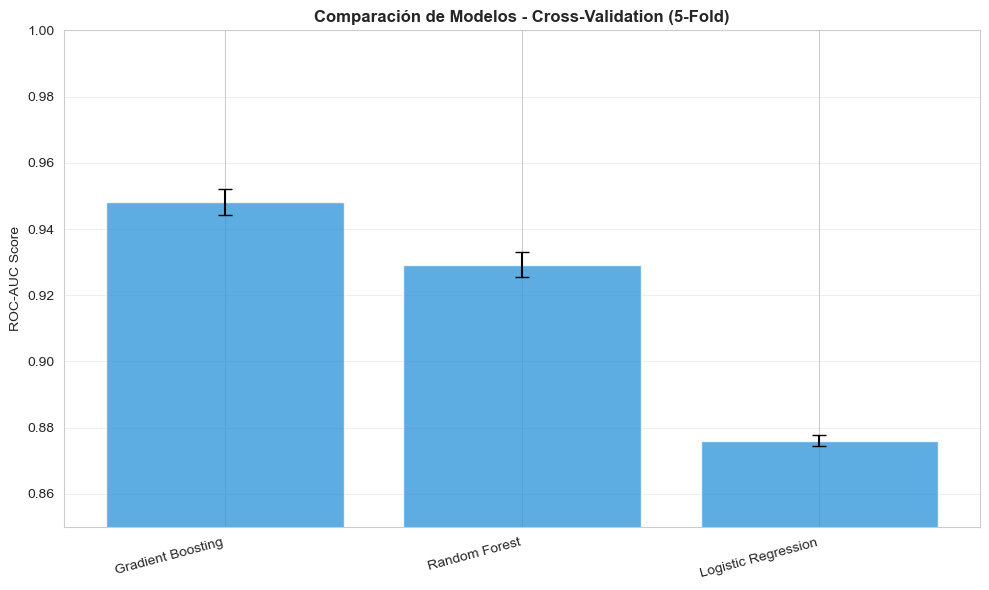

In [28]:
# Visualizar resultados de CV
cv_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean_AUC': [v['mean'] for v in cv_results.values()],
    'Std_AUC': [v['std'] for v in cv_results.values()]
}).sort_values('Mean_AUC', ascending=False)

print("\n📊 Resultados de Cross-Validation:")
print(cv_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
x = np.arange(len(cv_df))
plt.bar(x, cv_df['Mean_AUC'], yerr=cv_df['Std_AUC'], capsize=5, alpha=0.8, color='#3498db')
plt.xticks(x, cv_df['Model'], rotation=15, ha='right')
plt.ylabel('ROC-AUC Score')
plt.title('Comparación de Modelos - Cross-Validation (5-Fold)', fontweight='bold')
plt.ylim([0.85, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.1 Evaluación en Test Set

In [29]:
# Entrenar y evaluar todos los modelos en test set
test_results = {}

print("\n🧪 Evaluación en Test Set:\n")

for name, model in models.items():
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    test_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'roc_auc': roc_auc_score(y_test, y_proba),
        'f1': f1_score(y_test, y_pred),
        'avg_precision': average_precision_score(y_test, y_proba)
    }
    
    print(f"{name}:")
    print(f"  ROC-AUC: {test_results[name]['roc_auc']:.4f}")
    print(f"  F1 Score: {test_results[name]['f1']:.4f}")
    print(f"  Avg Precision: {test_results[name]['avg_precision']:.4f}")
    print()

print("✅ Evaluación en test completada")


🧪 Evaluación en Test Set:

Logistic Regression:
  ROC-AUC: 0.8770
  F1 Score: 0.6466
  Avg Precision: 0.7179

Random Forest:
  ROC-AUC: 0.9280
  F1 Score: 0.7866
  Avg Precision: 0.8769

Gradient Boosting:
  ROC-AUC: 0.9510
  F1 Score: 0.8364
  Avg Precision: 0.9093

✅ Evaluación en test completada


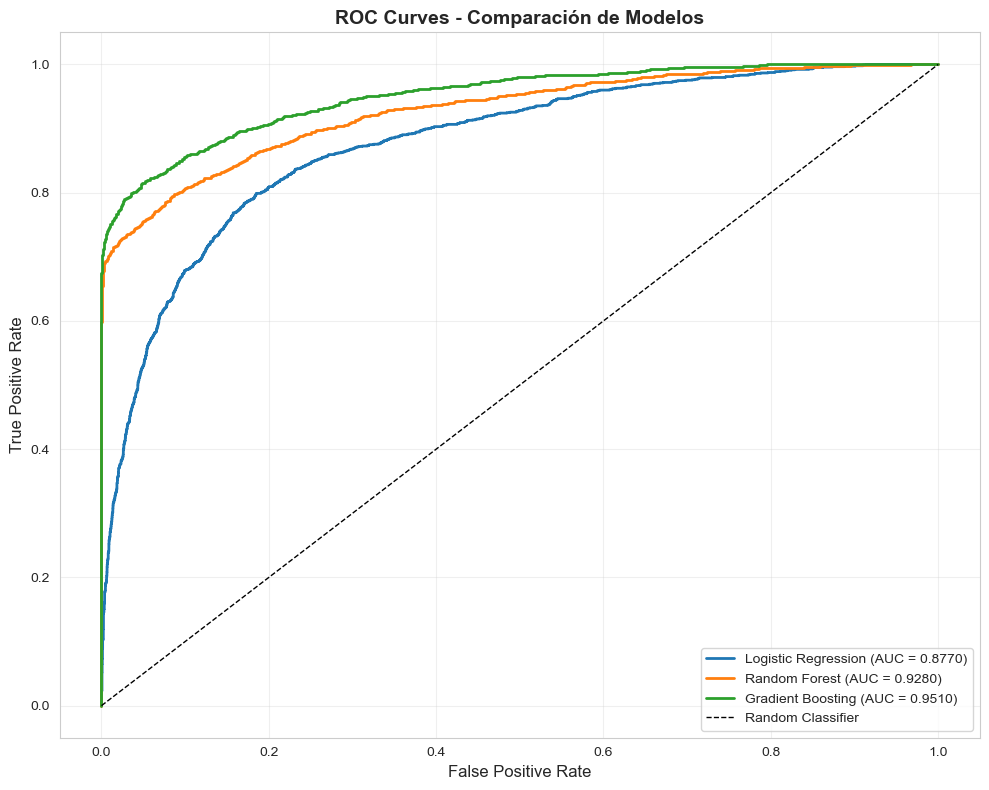

In [30]:
# ROC Curves para todos los modelos
plt.figure(figsize=(10, 8))

for name, results in test_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_proba'])
    auc = results['roc_auc']
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

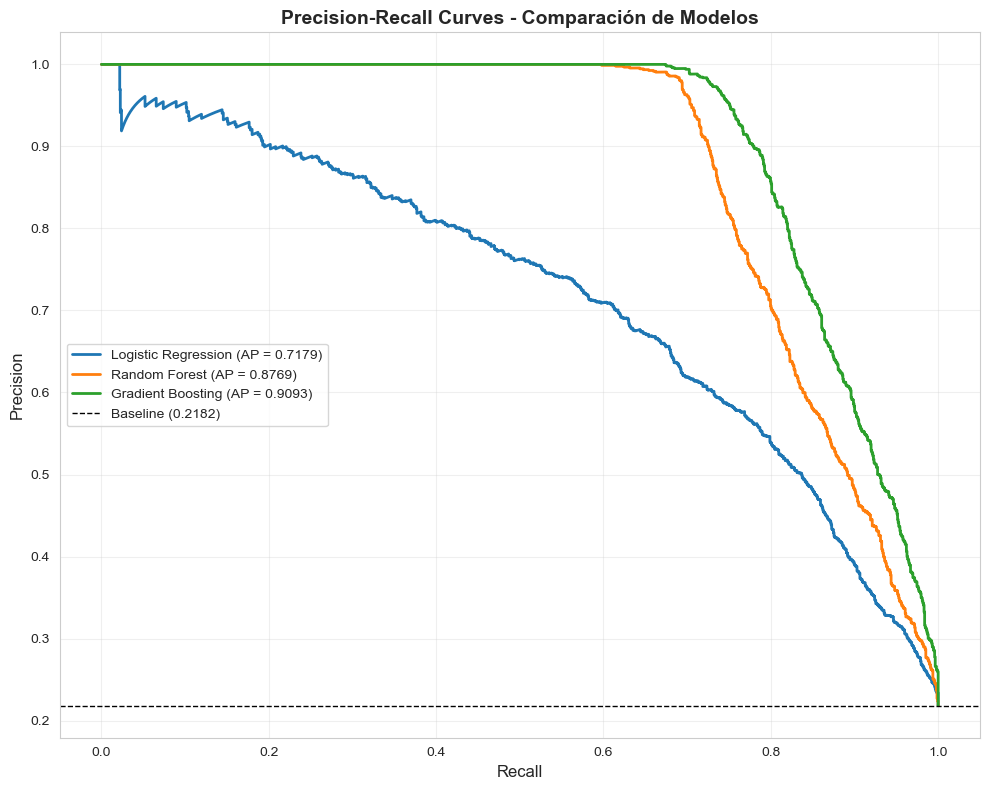

In [31]:
# Precision-Recall Curves
plt.figure(figsize=(10, 8))

for name, results in test_results.items():
    precision, recall, _ = precision_recall_curve(y_test, results['y_proba'])
    avg_prec = results['avg_precision']
    plt.plot(recall, precision, label=f"{name} (AP = {avg_prec:.4f})", linewidth=2)

# Baseline (proporción de positivos)
baseline = (y_test == 1).mean()
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.4f})', linewidth=1)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Experimento con SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) para balancear clases

In [32]:
# Random Forest con SMOTE
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

print("🔧 Entrenando Random Forest con SMOTE...")

# Cross-validation
smote_cv_scores = cross_val_score(
    smote_pipeline, X_train, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
)

print(f"\nCV ROC-AUC: {smote_cv_scores.mean():.4f} (+/- {smote_cv_scores.std() * 2:.4f})")

# Entrenar y evaluar en test
smote_pipeline.fit(X_train, y_train)
y_pred_smote = smote_pipeline.predict(X_test)
y_proba_smote = smote_pipeline.predict_proba(X_test)[:, 1]

print(f"\nTest ROC-AUC: {roc_auc_score(y_test, y_proba_smote):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_smote):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, target_names=['No Default', 'Default']))

🔧 Entrenando Random Forest con SMOTE...

CV ROC-AUC: 0.9276 (+/- 0.0069)

Test ROC-AUC: 0.9275
Test F1 Score: 0.7954

Classification Report:
              precision    recall  f1-score   support

  No Default       0.93      0.97      0.95      5095
     Default       0.87      0.73      0.80      1422

    accuracy                           0.92      6517
   macro avg       0.90      0.85      0.87      6517
weighted avg       0.92      0.92      0.92      6517



## 6. Hyperparameter Tuning

Optimización del mejor modelo usando RandomizedSearchCV

In [33]:
# Definir grid de hiperparámetros para Random Forest
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("🔍 Iniciando RandomizedSearchCV para Random Forest...")
print(f"  Combinaciones posibles: {np.prod([len(v) for v in param_distributions.values()]):,}")
print(f"  Combinaciones a probar: 50")
print(f"  Cross-validation: 5-fold estratificado")
print()

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones a probar
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train, y_train)

print("\n" + "="*60)
print("RESULTADOS DE HYPERPARAMETER TUNING")
print("="*60)
print(f"\nMejor score (CV): {rf_random.best_score_:.4f}")
print(f"\nMejores parámetros:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

🔍 Iniciando RandomizedSearchCV para Random Forest...
  Combinaciones posibles: 1,440
  Combinaciones a probar: 50
  Cross-validation: 5-fold estratificado

Fitting 5 folds for each of 50 candidates, totalling 250 fits

RESULTADOS DE HYPERPARAMETER TUNING

Mejor score (CV): 0.9381

Mejores parámetros:
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: 0.5
  max_depth: None
  class_weight: balanced_subsample


In [34]:
# Evaluar mejor modelo en test set
best_rf = rf_random.best_estimator_

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("EVALUACIÓN DEL MEJOR MODELO EN TEST SET")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['No Default', 'Default']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_best):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba_best):.4f}")


EVALUACIÓN DEL MEJOR MODELO EN TEST SET
              precision    recall  f1-score   support

  No Default       0.93      0.99      0.96      5095
     Default       0.97      0.73      0.83      1422

    accuracy                           0.94      6517
   macro avg       0.95      0.86      0.90      6517
weighted avg       0.94      0.94      0.93      6517


ROC-AUC Score: 0.9396
F1 Score: 0.8311
Average Precision: 0.8959


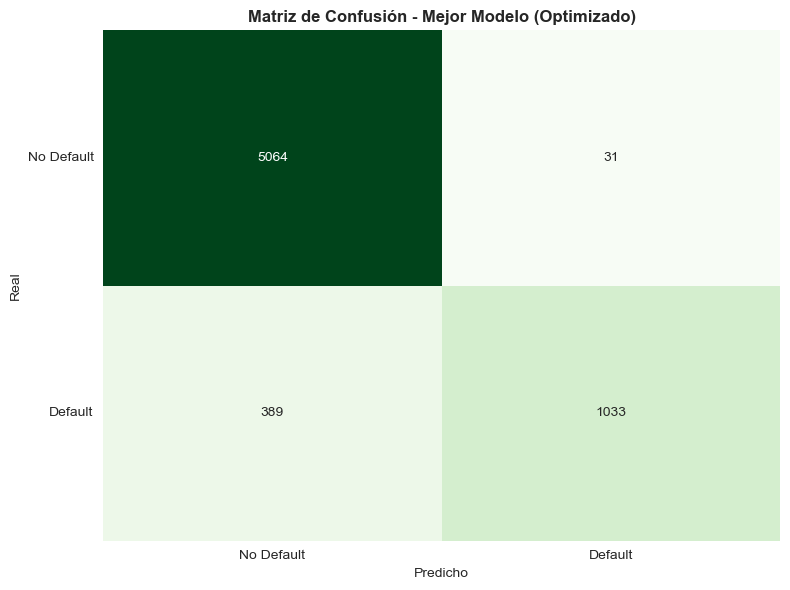


📊 Análisis Detallado:
  True Negatives: 5,064 (99.39% de No Defaults correctos)
  False Positives: 31 (0.61% de falsos positivos)
  False Negatives: 389 (27.36% de defaults perdidos)
  True Positives: 1,033 (72.64% de defaults detectados)


In [35]:
# Matriz de confusión del mejor modelo
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Matriz de Confusión - Mejor Modelo (Optimizado)', fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.xticks([0.5, 1.5], ['No Default', 'Default'])
plt.yticks([0.5, 1.5], ['No Default', 'Default'], rotation=0)
plt.tight_layout()
plt.show()

# Análisis detallado
tn, fp, fn, tp = cm_best.ravel()
print(f"\n📊 Análisis Detallado:")
print(f"  True Negatives: {tn:,} ({tn/(tn+fp)*100:.2f}% de No Defaults correctos)")
print(f"  False Positives: {fp:,} ({fp/(tn+fp)*100:.2f}% de falsos positivos)")
print(f"  False Negatives: {fn:,} ({fn/(fn+tp)*100:.2f}% de defaults perdidos)")
print(f"  True Positives: {tp:,} ({tp/(fn+tp)*100:.2f}% de defaults detectados)")

## 7. Comparación Final de Todos los Modelos

In [36]:
# Crear tabla comparativa
comparison_data = []

# Modelos base
for name, results in test_results.items():
    comparison_data.append({
        'Model': name,
        'ROC_AUC': results['roc_auc'],
        'F1_Score': results['f1'],
        'Avg_Precision': results['avg_precision']
    })

# SMOTE
comparison_data.append({
    'Model': 'Random Forest + SMOTE',
    'ROC_AUC': roc_auc_score(y_test, y_proba_smote),
    'F1_Score': f1_score(y_test, y_pred_smote),
    'Avg_Precision': average_precision_score(y_test, y_proba_smote)
})

# Mejor modelo optimizado
comparison_data.append({
    'Model': 'Random Forest (Optimizado)',
    'ROC_AUC': roc_auc_score(y_test, y_proba_best),
    'F1_Score': f1_score(y_test, y_pred_best),
    'Avg_Precision': average_precision_score(y_test, y_proba_best)
})

comparison_df = pd.DataFrame(comparison_data).sort_values('ROC_AUC', ascending=False)

print("\n" + "="*70)
print("COMPARACIÓN FINAL DE MODELOS")
print("="*70)
print(comparison_df.to_string(index=False))
print()


COMPARACIÓN FINAL DE MODELOS
                     Model  ROC_AUC  F1_Score  Avg_Precision
         Gradient Boosting 0.950980  0.836407       0.909308
Random Forest (Optimizado) 0.939584  0.831054       0.895863
             Random Forest 0.927986  0.786642       0.876947
     Random Forest + SMOTE 0.927480  0.795411       0.874797
       Logistic Regression 0.876957  0.646557       0.717913



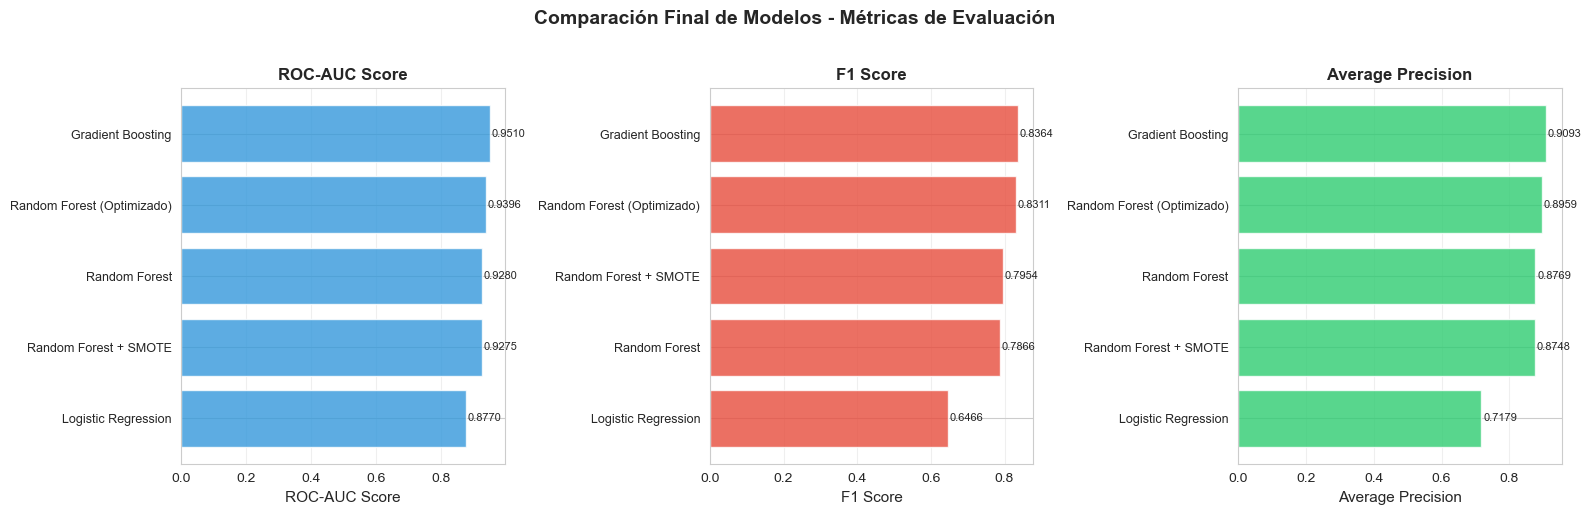

In [37]:
# Visualización de la comparación
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['ROC_AUC', 'F1_Score', 'Avg_Precision']
titles = ['ROC-AUC Score', 'F1 Score', 'Average Precision']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx]
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    y_pos = np.arange(len(sorted_df))
    ax.barh(y_pos, sorted_df[metric], color=color, alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_df['Model'], fontsize=9)
    ax.set_xlabel(title, fontsize=11)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=8)

plt.suptitle('Comparación Final de Modelos - Métricas de Evaluación', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Exportar Mejor Modelo

In [38]:
# Guardar el mejor modelo
joblib.dump(best_rf, 'best_model_rf_optimized.pkl')
print("✅ Mejor modelo guardado como 'best_model_rf_optimized.pkl'")

# Guardar métricas
model_metrics = {
    'model_name': 'Random Forest (Optimizado)',
    'best_params': rf_random.best_params_,
    'cv_score': rf_random.best_score_,
    'test_roc_auc': roc_auc_score(y_test, y_proba_best),
    'test_f1': f1_score(y_test, y_pred_best),
    'test_avg_precision': average_precision_score(y_test, y_proba_best),
    'confusion_matrix': cm_best.tolist()
}

joblib.dump(model_metrics, 'model_metrics.pkl')
print("✅ Métricas guardadas como 'model_metrics.pkl'")

# Guardar predicciones para análisis posterior
predictions = {
    'y_test': y_test,
    'y_pred': y_pred_best,
    'y_proba': y_proba_best
}

joblib.dump(predictions, 'test_predictions.pkl')
print("✅ Predicciones guardadas como 'test_predictions.pkl'")

print("\n" + "="*60)
print("🎉 MODEL PROTOTYPING AND TUNING COMPLETADO")
print("="*60)
print("\nArchivos generados:")
print("  1. best_model_rf_optimized.pkl")
print("  2. model_metrics.pkl")
print("  3. test_predictions.pkl")
print("\nPróximo paso: Notebook 04 - Model Interpretation and Insights")

✅ Mejor modelo guardado como 'best_model_rf_optimized.pkl'
✅ Métricas guardadas como 'model_metrics.pkl'
✅ Predicciones guardadas como 'test_predictions.pkl'

🎉 MODEL PROTOTYPING AND TUNING COMPLETADO

Archivos generados:
  1. best_model_rf_optimized.pkl
  2. model_metrics.pkl
  3. test_predictions.pkl

Próximo paso: Notebook 04 - Model Interpretation and Insights
